Objectives
* We want to compare the accuracy of domain boundaries of HMM vs TED (foldseek)
* To do that we need to see where the domain boundaries overlap
* We are using just the TED/HMM annotations in human as a reduced dataset for testing
* We are going to randomly select entries for manual analysis from bins according to: 
  * domain overlap (HMM vs TED)
  * evalue (of HMM domain match)

In [57]:
data_file = 'data/domain_comparison_results_human.tsv'
output_file = 'results/domain_comparison_results_human.processed.tsv'

# do not consider any domains below this length
filter_min_length = 100

# max number of entries per bin
max_entries_per_bin = 10

# Define the overlap bins
overlap_bins = [(41, 50), (51, 60), (61, 70), (71, 80), (81, 90), (91, 100)]

# Define the evalue bins
evalue_bins = [(0, 1e-5), (1e-5, 1e-10), (1e-10, 1e-20), (1e-20, 1e-30), (1e-30, 1e-40), (1e-40, 1e-50), (1e-50, 1e-200)]


Read original data

In [58]:
import pandas as pd


# Replace 'filename.csv' with the actual filename of your domain comparison results
df = pd.read_csv(data_file, sep='\t')

# Display the loaded data
df.head(5)


,chain_id,foldseek_domain_id,foldseek_cath_code,hmm_evalue,overlap_percentage,hmm_boundaries,foldseek_boundaries
0,AF-A0A024QZP7-F1-model_v4,AF-A0A024QZP7-F1-model_v4_TED01,3.30.200.20,1.200000e-25,92.86,1-84,5-82
1,AF-A0A024QZP7-F1-model_v4,AF-A0A024QZP7-F1-model_v4_TED02,1.10.510.10,1.100000e-74,99.53,85-297,86-297
2,AF-A0A024R0K5-F1-model_v4,AF-A0A024R0K5-F1-model_v4_TED01,2.60.40.10,2.600000e-28,89.81,35-141,45-142
3,AF-A0A024R0K5-F1-model_v4,AF-A0A024R0K5-F1-model_v4_TED02,2.60.40.10,5.900000e-16,86.60,142-238,149-232
4,AF-A0A024R0K5-F1-model_v4,AF-A0A024R0K5-F1-model_v4_TED03,2.60.40.10,3.200000e-13,94.05,239-322,242-320


Tidy up data

In [59]:
# normalise boundaries

df['hmm_boundaries'] = df['hmm_boundaries'].apply(lambda x: x.replace(',', '_'))

Add domain lengths to dataset

In [60]:
import re

def get_length_from_chopping(x):
    res = 0
    for seg in re.split(r'_', x):
        start, stop = seg.split('-')
        res += int(stop) - int(start) + 1
    return res

df['hmm_boundaries_length'] = df['hmm_boundaries'].apply(lambda x: get_length_from_chopping(x))
df['foldseek_boundaries_length'] = df['foldseek_boundaries'].apply(lambda x: get_length_from_chopping(x))

df.head(5)

,chain_id,foldseek_domain_id,foldseek_cath_code,hmm_evalue,overlap_percentage,hmm_boundaries,foldseek_boundaries,hmm_boundaries_length,foldseek_boundaries_length
0,AF-A0A024QZP7-F1-model_v4,AF-A0A024QZP7-F1-model_v4_TED01,3.30.200.20,1.200000e-25,92.86,1-84,5-82,84,78
1,AF-A0A024QZP7-F1-model_v4,AF-A0A024QZP7-F1-model_v4_TED02,1.10.510.10,1.100000e-74,99.53,85-297,86-297,213,212
2,AF-A0A024R0K5-F1-model_v4,AF-A0A024R0K5-F1-model_v4_TED01,2.60.40.10,2.600000e-28,89.81,35-141,45-142,107,98
3,AF-A0A024R0K5-F1-model_v4,AF-A0A024R0K5-F1-model_v4_TED02,2.60.40.10,5.900000e-16,86.60,142-238,149-232,97,84
4,AF-A0A024R0K5-F1-model_v4,AF-A0A024R0K5-F1-model_v4_TED03,2.60.40.10,3.200000e-13,94.05,239-322,242-320,84,79


Have a look at distribution of domain lengths (and impact of applying minimum length filter)

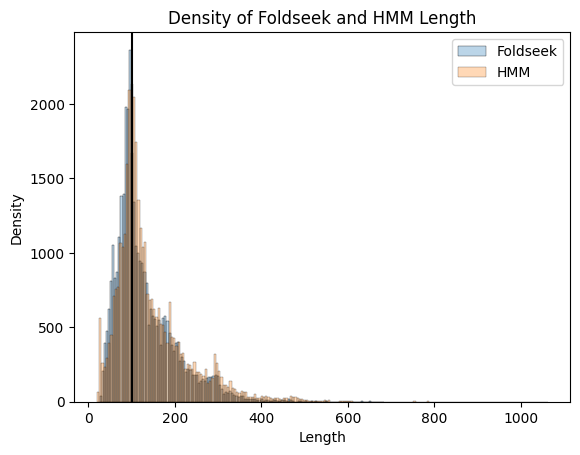

In [61]:

import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.histplot(data=df, x='foldseek_boundaries_length', label='Foldseek', alpha=0.3)
sns.histplot(data=df, x='hmm_boundaries_length', label='HMM', alpha=0.3)

ax.axvline(x = filter_min_length,
           ymin = 0, # Bottom of the plot
           ymax = 2000, 
           color = 'black') # Top of the plot

plt.legend()
plt.xlabel('Length')
plt.ylabel('Density')
plt.title('Density of Foldseek and HMM Length')
plt.show()

Filter the data

In [62]:
# make sure both domains are > 100 residues
filtered_df = df[(df['hmm_boundaries_length'] >= filter_min_length) & (df['foldseek_boundaries_length'] >= filter_min_length)]

print(f"Original: {len(df)} rows")
print(f"Filter (length < {filter_min_length}): {len(filtered_df)} rows")

Original: 36090 rows
Filter (length < 100): 18945 rows


Generate random entries within overlap/evalue bins 

In [63]:

from pathlib import Path
import random

_df = filtered_df

def create_bins():

    # Create an empty list to store the subset
    subset = []

    # Iterate over the bins
    for overlap_bin_range in overlap_bins:

        for evalue_bin_range in evalue_bins:

            # Filter the dataframe based on the overlap range
            filtered_rows = _df[
                (_df['overlap_percentage'] >= overlap_bin_range[0]) & (_df['overlap_percentage'] <= overlap_bin_range[1]) &
                (_df['hmm_evalue'] < evalue_bin_range[0]) & (_df['hmm_evalue'] >= evalue_bin_range[1])
            ]

            # Check if there are at least 20 rows in the filtered dataframe
            if len(filtered_rows) >= max_entries_per_bin:
                # Randomly select 20 rows from the filtered dataframe
                random_rows = filtered_rows.sample(n=max_entries_per_bin, random_state=42)
                subset.append(random_rows)
            else:
                # If there are less than 20 rows, add all the rows to the subset
                subset.append(filtered_rows)

    # Concatenate the subsets into a single dataframe
    subset_df = pd.concat(subset)

    # Reset the index of the subset dataframe
    subset_df.reset_index(drop=True, inplace=True)

    # Return the subset dataframe
    return subset_df

if Path(output_file).exists():
    # Load the subset dataframe from file
    subset_df = pd.read_csv(output_file, sep='\t', index=False)

else:
    # Create the subset dataframe
    subset_df = create_bins()

    # Write results to file
    subset_df.to_csv(output_file, sep='\t', index=False)

# Print the subset dataframe
subset_df

,chain_id,foldseek_domain_id,foldseek_cath_code,hmm_evalue,overlap_percentage,hmm_boundaries,foldseek_boundaries,hmm_boundaries_length,foldseek_boundaries_length
0,AF-Q8N3P4-F1-model_v4,AF-Q8N3P4-F1-model_v4_TED01,2.130.10.10,1.400000e-09,48.03,93-328,134-498,236,365
1,AF-Q9BXT8-F1-model_v4,AF-Q9BXT8-F1-model_v4_TED03,2.40.50.90,4.900000e-07,43.42,554-653,418-494_503-652,100,227
2,AF-A0A6Q8PHD2-F1-model_v4,AF-A0A6Q8PHD2-F1-model_v4_TED01,1.25.10.10,9.600000e-06,46.95,68-329,82-204,262,123
3,AF-A0A2R8YFD9-F1-model_v4,AF-A0A2R8YFD9-F1-model_v4_TED01,3.40.930.10,2.700000e-07,45.74,192-316,66-73_94-168_177-293,125,200
4,AF-Q13023-F1-model_v4,AF-Q13023-F1-model_v4_TED03,1.20.58.60,1.800000e-09,44.73,959-1195,963-1068,237,106
...,...,...,...,...,...,...,...,...,...
355,AF-O95479-F1-model_v4,AF-O95479-F1-model_v4_TED03,3.40.50.1360,2.600000e-59,97.59,548-790,543-791,243,249
356,AF-A0A3B3ITV3-F1-model_v4,AF-A0A3B3ITV3-F1-model_v4_TED01,2.130.10.10,1.700000e-98,92.19,1-320,3-171_194-319,320,295
357,AF-P19447-F1-model_v4,AF-P19447-F1-model_v4_TED03,3.40.50.300,1.400000e-80,94.87,497-730,504-725,234,222
358,AF-E9PKV4-F1-model_v4,AF-E9PKV4-F1-model_v4_TED01,2.60.40.340,1.500000e-66,97.06,20-189,21-185,170,165
